<a href="https://colab.research.google.com/github/newstage75/ML_study/blob/master/%E6%9C%80%E7%9F%ADPytorch/%EF%BC%98%E7%AB%A0%EF%BC%88%E9%9A%A0%E3%82%8C%EF%BC%92%E5%B1%A4%EF%BC%89MNIST%E3%82%92%E4%BD%BF%E3%81%A3%E3%81%9F%E6%95%B0%E5%AD%97%E8%AA%8D%E8%AD%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#８章（隠れ２層）MNISTを使った数字認識

ランタイプの変更からGPUに変更している。

In [ ]:
# 必要ライブラリの導入

!pip install japanize_matplotlib | tail -n 1
!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1

In [ ]:
# 必要ライブラリのインポート

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from IPython.display import display

In [ ]:
# torch関連ライブラリのインポート

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot

In [ ]:
# warning表示off
import warnings
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=5)

###GPU利用

####GPU利用のルール

1.テンソル変数はデータがCPU/GPU上のどちらにあるのかを属性として持っている

2.CPUとGPU間のデータはto関数で転送する

3.2つの変数が両方ともGPU上にある場合、演算はGPUで行われる

4.変数の片方がCPU、もう一方がGPUの場合はエラーになる。

In [ ]:
#デバイスの割り当て
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
#テスト用tensor変数x, y
x_np = np.arange(-2.0, 2.1, 0.25)
y_np = np.arange(-1.0, 3.1, 0.25)
x = torch.tensor(x_np).float()
y = torch.tensor(y_np).float()

z = x * y
print(z)

tensor([ 2.0000,  1.3125,  0.7500,  0.3125, -0.0000, -0.1875, -0.2500, -0.1875,
         0.0000,  0.3125,  0.7500,  1.3125,  2.0000,  2.8125,  3.7500,  4.8125,
         6.0000])


In [ ]:
#変数xをGPUに送る
x = x.to(device)

print('x: ', x.device)
print('y: ', y.device)

x:  cuda:0
y:  cpu


In [ ]:
#変数yもGPUに送る
y = y.to(device)

z = x * y
print(z)

tensor([ 2.0000,  1.3125,  0.7500,  0.3125, -0.0000, -0.1875, -0.2500, -0.1875,
         0.0000,  0.3125,  0.7500,  1.3125,  2.0000,  2.8125,  3.7500,  4.8125,
         6.0000], device='cuda:0')


In [ ]:
#データ準備1(データセットによる読み込み)

#ライブラリインポート
import torchvision.datasets as datasets

# ダウンロード先ディレクトリ名
data_root = './data'

train_set0 = datasets.MNIST(
    #元データダウンロード先の指定
    root = data_root,
    #訓練データか検証データか
    train = True,
    #元データがない場合にダウンロードするか
    download = True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
#ダウンロードしたの確認

!ls -lR ./data/MNIST

./data/MNIST:
total 4
drwxr-xr-x 2 root root 4096 May 23 11:08 raw

./data/MNIST/raw:
total 65008
-rw-r--r-- 1 root root  7840016 May 23 11:08 t10k-images-idx3-ubyte
-rw-r--r-- 1 root root  1648877 May 23 11:08 t10k-images-idx3-ubyte.gz
-rw-r--r-- 1 root root    10008 May 23 11:08 t10k-labels-idx1-ubyte
-rw-r--r-- 1 root root     4542 May 23 11:08 t10k-labels-idx1-ubyte.gz
-rw-r--r-- 1 root root 47040016 May 23 11:08 train-images-idx3-ubyte
-rw-r--r-- 1 root root  9912422 May 23 11:08 train-images-idx3-ubyte.gz
-rw-r--r-- 1 root root    60008 May 23 11:08 train-labels-idx1-ubyte
-rw-r--r-- 1 root root    28881 May 23 11:08 train-labels-idx1-ubyte.gz


In [ ]:
#データの件数の確認
print('データ件数: ', len(train_set0))

#最初の要素の取得
image, label = train_set0[0]

print('入力データの型:', type(image))
print('正解データの型:', type(label))

データ件数:  60000
入力データの型: <class 'PIL.Image.Image'>
正解データの型: <class 'int'>


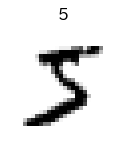

In [ ]:
#入力データの画像表示
plt.figure(figsize=(2,3))
plt.title(f'{label}')
plt.imshow(image,cmap='gray_r')
plt.axis('off')
plt.show()

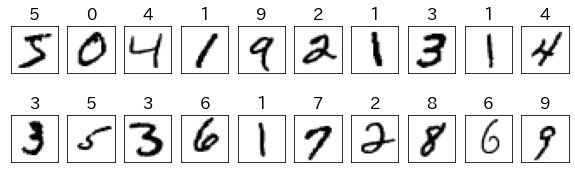

In [ ]:
#正解データ付きで、最初の20個のイメージ表示
plt.figure(figsize=(10, 3))
for i in range(20):
  ax = plt.subplot(2, 10, i + 1)

  #imageとlabelの取得
  image, label = train_set0[i]

  #イメージ表示
  plt.imshow(image, cmap='gray_r')
  ax.set_title(f'{label}')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
#データ前処理
#Step1 ToTensorの利用

import torchvision.transforms as transforms

transform1 = transforms.Compose([
        #　データのTensor化
        transforms.ToTensor(),
])

train_set1 = datasets.MNIST(
    root=data_root, train=True, download=True,
    transform = transform1)

In [ ]:
#変換結果の確認
image, label = train_set1[0]
print('入力データの型: ', type(image))
print('入力データのshape: ', image.shape)
print('最小値: ', image.data.min())
print('最大値: ', image.data.max())

入力データの型:  <class 'torch.Tensor'>
入力データのshape:  torch.Size([1, 28, 28])
最小値:  tensor(0.)
最大値:  tensor(1.)


In [ ]:
#Step2 Notmalizeの利用
transform2 = transforms.Compose([
        #データのTensor化
        transforms.ToTensor(),

        #データの正規化
        transforms.Normalize(0.5, 0.5),
])

train_set2 = datasets.MNIST(
    root = data_root, train = True, download = True,
    transform = transform2)

In [ ]:
#変換結果の確認
image, label = train_set2[0]
print('shape: ', image.shape)
print('最小値: ', image.data.min())
print('最大値: ', image.data.max())

shape:  torch.Size([1, 28, 28])
最小値:  tensor(-1.)
最大値:  tensor(1.)


In [ ]:
#Step3 Lambdaを利用して1階テンソル化
transform3 = transforms.Compose([
        # データのTensor化
        transforms.ToTensor(),

        #データの正規化
        transforms.Normalize(0.5, 0.5),

        #Tensorの1階テンソル化
        transforms.Lambda(lambda x: x.view(-1)),
])

train_set3 = datasets.MNIST(
    root = data_root, train = True,
    download=True, transform=transform3)

In [ ]:
#変換結果の確認
image, label = train_set3[0]
print('shape: ', image.shape)
print('最小値: ', image.data.min())
print('最大値: ', image.data.max())

shape:  torch.Size([784])
最小値:  tensor(-1.)
最大値:  tensor(1.)


## 最終的な実装

#### データ変換用関数 Transforms
#### (1) Imageをテンソル化
#### (2) [0, 1]の範囲の値を[-1, 1]の範囲にする
#### (3) データのshapeを[1, 28, 28]から[784]に変換


In [ ]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.5),
        transforms.Lambda(lambda x: x.view(-1)),
])

In [ ]:
#データ取得用関数Dataset

#訓練用データセットの定義
train_set = datasets.MNIST(
    root = data_root, train = True,
    download = True, transform = transform)

#検証データセットの定義
test_set = datasets.MNIST(
    root = data_root, train = False,
    download = True, transform = transform)

### データローダーによるミニバッチ用データ生成

In [ ]:
from torch.utils.data import DataLoader

batch_size = 500

#訓練用データローダー（シャッフルもする）
train_loader = DataLoader(
    train_set, batch_size = batch_size,
    shuffle = True)

#検証用データローダー(シャッフル不要)
test_loader = DataLoader(
    train_set, batch_size = batch_size,
    shuffle = False)

In [ ]:
#何組のデータが取得できるか
print(len(train_loader))

#DataLoarderから最初の1セットを取得する
for images, labels in train_loader:
  break

print(images.shape)
print(labels.shape)

120
torch.Size([500, 784])
torch.Size([500])


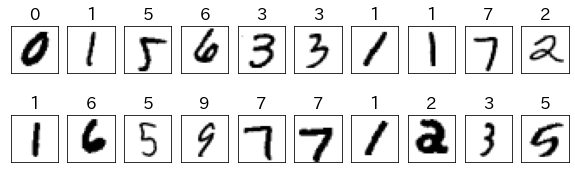

In [ ]:
#イメージ表示
plt.figure(figsize=(10, 3))
for i in range(20):
  ax = plt.subplot(2, 10, i+1)

  #numpyに変換
  image = images[i].numpy()
  label = labels[i]

  #imgの範囲を[0, 1]に戻す
  image2 = (image + 1)/2
  #イメージ表示
  plt.imshow(image2.reshape(28, 28), cmap='gray_r')
  ax.set_title(f'{label}')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
#モデル定義
n_input = image.shape[0]

#出力次元数
n_output = len(set(list(labels.data.numpy())))

#隠れ層のノード数
n_hidden = 128

#結果確認
print(n_input)
print(n_output)
print(n_hidden)

784
10
128


In [ ]:
#モデル定義
#784入力10出力、１隠れ層のニューラルネットワークモデル

class Net(nn.Module):
  def __init__(self, n_input, n_output, n_hidden):
    super().__init__()
    self.l1 = nn.Linear(n_input, n_hidden)

    self.l2 = nn.Linear(n_hidden, n_output)

    self.relu = nn.ReLU(inplace=True)

  def forward(self, x):
    x1 = self.l1(x)
    x2 = self.relu(x1)
    x3 = self.l2(x2)
    return x3

In [ ]:
#乱数の固定化
torch.manual_seed(123)
torch.cuda.manual_seed(123)

#モデルインスタンス生成
net = Net(n_input, n_output, n_hidden)

#モデルをGPU側に送る
net = net.to(device)

In [ ]:
#最適化アルゴリズムと損失関数
lr = 0.01

#アルゴリズム: 勾配降下法
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

#損失関数
criterion = nn.CrossEntropyLoss()

In [ ]:
#モデル確認
for parameter in net.named_parameters():
  print(parameter)

('l1.weight', Parameter containing:
tensor([[-0.0146,  0.0012, -0.0177,  ...,  0.0277,  0.0200,  0.0315],
        [ 0.0184, -0.0322,  0.0175,  ...,  0.0089, -0.0028, -0.0033],
        [ 0.0092,  0.0261,  0.0075,  ...,  0.0061,  0.0267, -0.0258],
        ...,
        [ 0.0235, -0.0026, -0.0129,  ...,  0.0322, -0.0059, -0.0169],
        [-0.0328, -0.0258,  0.0124,  ..., -0.0049,  0.0006,  0.0334],
        [ 0.0187, -0.0076, -0.0202,  ...,  0.0325, -0.0159, -0.0240]],
       device='cuda:0', requires_grad=True))
('l1.bias', Parameter containing:
tensor([ 0.0325, -0.0298,  0.0013,  0.0199,  0.0268, -0.0248, -0.0172, -0.0355,
         0.0122, -0.0048,  0.0214,  0.0202, -0.0243,  0.0015, -0.0276,  0.0296,
         0.0341, -0.0228,  0.0230,  0.0347, -0.0091, -0.0346,  0.0206, -0.0060,
         0.0329,  0.0047,  0.0180,  0.0101,  0.0177, -0.0309,  0.0228, -0.0224,
         0.0321,  0.0179,  0.0321,  0.0184,  0.0219, -0.0089,  0.0310, -0.0039,
        -0.0074, -0.0317,  0.0192, -0.0021,  0.0190

In [ ]:
print(net)

Net(
  (l1): Linear(in_features=784, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
)


In [ ]:
#モデルのサマリー表示
summary(net, (784,))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      --                        --
├─Linear: 1-1                            [128]                     100,480
├─ReLU: 1-2                              [128]                     --
├─Linear: 1-3                            [10]                      1,290
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
Total mult-adds (M): 12.87
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.41
Estimated Total Size (MB): 0.41

In [ ]:
#勾配降下法
#予測計算
for images, labels in train_loader:
  break

In [ ]:
#データローダーから取得したデータをGPUに送る
inputs = images.to(device)
labels = labels.to(device)

In [ ]:
#予測計算
outputs = net(inputs)

#結果確認
print(outputs)

tensor([[-0.3622, -0.1927, -0.0179,  ...,  0.1073,  0.1025, -0.0615],
        [-0.4072, -0.1814,  0.0716,  ...,  0.1866,  0.1975,  0.1161],
        [-0.3221, -0.0547, -0.2868,  ...,  0.1967, -0.0103,  0.1591],
        ...,
        [-0.2091, -0.1058,  0.2365,  ...,  0.1360,  0.0665,  0.0987],
        [-0.2756, -0.2012,  0.1703,  ...,  0.1223,  0.2388,  0.0233],
        [-0.3045, -0.2458,  0.1416,  ...,  0.1012,  0.0820, -0.1457]],
       device='cuda:0', grad_fn=<AddmmBackward0>)


2.332887649536133


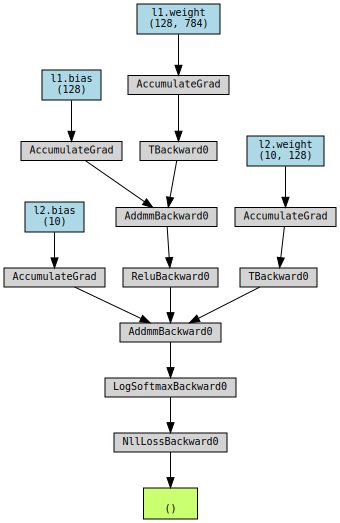

In [ ]:
#損失関数
loss = criterion(outputs, labels)

#損失値の取得
print(loss.item())

#損失の計算グラフ可視化
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

In [ ]:
#勾配計算の実行
loss.backward()

In [ ]:
#勾配計算の結果
w = net.to('cpu')
print(w.l1.weight.grad.numpy())
print(w.l1.bias.grad.numpy())
print(w.l2.weight.grad.numpy())
print(w.l2.bias.grad.numpy())

[[-0.00071 -0.00071 -0.00071 ... -0.00071 -0.00071 -0.00071]
 [ 0.00768  0.00768  0.00768 ...  0.00768  0.00768  0.00768]
 [-0.00179 -0.00179 -0.00179 ... -0.00179 -0.00179 -0.00179]
 ...
 [-0.00076 -0.00076 -0.00076 ... -0.00076 -0.00076 -0.00076]
 [ 0.0011   0.0011   0.0011  ...  0.0011   0.0011   0.0011 ]
 [-0.00009 -0.00009 -0.00009 ... -0.00009 -0.00009 -0.00009]]
[ 0.00071 -0.00768  0.00179  0.00085 -0.00004  0.00004  0.00135 -0.00085
  0.00254 -0.00164  0.00086 -0.00196  0.00059  0.00252 -0.00256  0.00075
  0.00605 -0.00109 -0.00177  0.00799  0.00627  0.00256 -0.00358  0.00563
 -0.00059 -0.00379  0.00343  0.      -0.00257 -0.00319 -0.00055  0.00345
  0.00175  0.00001  0.00007  0.00024  0.0047  -0.00124  0.00215  0.00183
  0.00371 -0.00607  0.00109  0.00972 -0.0017  -0.00124 -0.00044 -0.00102
 -0.00306 -0.00029 -0.0008   0.00041  0.00009 -0.00159 -0.00205 -0.00007
 -0.00059 -0.00235 -0.00043  0.00292  0.00128 -0.00846  0.0013   0.00154
  0.      -0.00055  0.00403 -0.00165 -0.0052

In [ ]:
#パラメータ修正
optimizer.step()

In [ ]:
#パラメータ値の表示
print(net.l1.weight)
print(net.l1.bias)

Parameter containing:
tensor([[-0.0146,  0.0012, -0.0177,  ...,  0.0278,  0.0200,  0.0316],
        [ 0.0183, -0.0322,  0.0174,  ...,  0.0088, -0.0029, -0.0034],
        [ 0.0092,  0.0261,  0.0075,  ...,  0.0061,  0.0267, -0.0258],
        ...,
        [ 0.0235, -0.0026, -0.0129,  ...,  0.0323, -0.0059, -0.0169],
        [-0.0329, -0.0258,  0.0124,  ..., -0.0049,  0.0006,  0.0334],
        [ 0.0187, -0.0076, -0.0202,  ...,  0.0325, -0.0159, -0.0240]],
       requires_grad=True)
Parameter containing:
tensor([ 3.2475e-02, -2.9682e-02,  1.2742e-03,  1.9874e-02,  2.6836e-02,
        -2.4759e-02, -1.7201e-02, -3.5517e-02,  1.2199e-02, -4.7449e-03,
         2.1379e-02,  2.0187e-02, -2.4297e-02,  1.4928e-03, -2.7613e-02,
         2.9618e-02,  3.4051e-02, -2.2777e-02,  2.2983e-02,  3.4580e-02,
        -9.1870e-03, -3.4619e-02,  2.0599e-02, -6.0632e-03,  3.2937e-02,
         4.7784e-03,  1.7949e-02,  1.0102e-02,  1.7700e-02, -3.0853e-02,
         2.2817e-02, -2.2391e-02,  3.2049e-02,  1.7890e-0

In [ ]:
#繰り返し計算
#乱数の固定化
torch.manual_seed(123)
torch.cuda.manual_seed(123)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

#学習率
lr = 0.01

#モデルインスタンスの生成
net = Net(n_input, n_output, n_hidden).to(device)

#損失関数
criterion = nn.CrossEntropyLoss()

#最適化関数:勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

#繰り返し回数
num_epochs = 100

#評価結果記録用
history = np.zeros((0,5))

In [ ]:
#tqdmライブラリのインポート
from tqdm.notebook import tqdm

for epoch in range(num_epochs):
  train_acc, train_loss = 0, 0
  val_acc, val_loss = 0, 0
  n_train, n_test = 0, 0

  #訓練フェーズ
  for inputs, labels in tqdm(train_loader):
    n_train += len(labels)

    #GPUへ転送
    inputs = inputs.to(device)
    labels = labels.to(device)

    #勾配の初期化
    optimizer.zero_grad()

    #予測計算
    outputs = net(inputs)

    # 損失計算
    loss = criterion(outputs, labels)

    #勾配計算
    loss.backward()

    #パラメータ修正
    optimizer.step()

    #予測ラベル導出
    predicted = torch.max(outputs, 1)[1]

    #損失と精度の計算
    train_loss += loss.item()
    train_acc += (predicted == labels).sum().item()

  #予測フェーズ
  for inputs_test, labels_test in test_loader:
    n_test += len(labels_test)

    inputs_test = inputs_test.to(device)
    labels_test = labels_test.to(device)

    #予測計算
    outputs_test = net(inputs_test)

    #損失計算
    loss_test = criterion(outputs_test, labels_test)

    #予測ラベル導出
    predicted_test = torch.max(outputs_test, 1)[1]

    #損失と精度の計算
    val_loss += loss_test.item()
    val_acc += (predicted_test == labels_test).sum().item()

# 評価値の算出・記録
  train_acc = train_acc / n_train
  val_acc = val_acc / n_test
  train_loss = train_loss * batch_size / n_train
  val_loss = val_loss * batch_size / n_test
  print (f'Epoch [{epoch+1}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
  item = np.array([epoch+1 , train_loss, train_acc, val_loss, val_acc])
  history = np.vstack((history, item))

  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [1/100], loss: 1.82932 acc: 0.56958 val_loss: 1.34430, val_acc: 0.73488


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [2/100], loss: 1.03888 acc: 0.79537 val_loss: 0.81808, val_acc: 0.82282


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [3/100], loss: 0.70809 acc: 0.84110 val_loss: 0.62273, val_acc: 0.85395


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [4/100], loss: 0.57300 acc: 0.86057 val_loss: 0.53094, val_acc: 0.86720


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [5/100], loss: 0.50223 acc: 0.87102 val_loss: 0.47688, val_acc: 0.87638


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [6/100], loss: 0.45883 acc: 0.87877 val_loss: 0.44163, val_acc: 0.88173


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [7/100], loss: 0.42938 acc: 0.88327 val_loss: 0.41769, val_acc: 0.88535


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [8/100], loss: 0.40813 acc: 0.88743 val_loss: 0.39931, val_acc: 0.88897


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [9/100], loss: 0.39176 acc: 0.89067 val_loss: 0.38441, val_acc: 0.89145


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [10/100], loss: 0.37876 acc: 0.89313 val_loss: 0.37279, val_acc: 0.89522


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [11/100], loss: 0.36812 acc: 0.89592 val_loss: 0.36272, val_acc: 0.89713


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [12/100], loss: 0.35910 acc: 0.89783 val_loss: 0.35491, val_acc: 0.89968


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [13/100], loss: 0.35147 acc: 0.89977 val_loss: 0.34765, val_acc: 0.90012


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [14/100], loss: 0.34477 acc: 0.90130 val_loss: 0.34074, val_acc: 0.90247


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [15/100], loss: 0.33860 acc: 0.90312 val_loss: 0.33559, val_acc: 0.90362


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [16/100], loss: 0.33333 acc: 0.90412 val_loss: 0.33032, val_acc: 0.90472


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [17/100], loss: 0.32843 acc: 0.90520 val_loss: 0.32531, val_acc: 0.90627


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [18/100], loss: 0.32380 acc: 0.90697 val_loss: 0.32180, val_acc: 0.90712


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [19/100], loss: 0.31950 acc: 0.90805 val_loss: 0.31676, val_acc: 0.90827


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [20/100], loss: 0.31587 acc: 0.90903 val_loss: 0.31291, val_acc: 0.90967


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [21/100], loss: 0.31199 acc: 0.91030 val_loss: 0.30936, val_acc: 0.91128


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [22/100], loss: 0.30842 acc: 0.91095 val_loss: 0.30612, val_acc: 0.91192


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [23/100], loss: 0.30507 acc: 0.91193 val_loss: 0.30304, val_acc: 0.91300


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [24/100], loss: 0.30191 acc: 0.91318 val_loss: 0.29976, val_acc: 0.91407


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [25/100], loss: 0.29883 acc: 0.91407 val_loss: 0.29722, val_acc: 0.91472


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [26/100], loss: 0.29597 acc: 0.91495 val_loss: 0.29422, val_acc: 0.91552


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [27/100], loss: 0.29311 acc: 0.91658 val_loss: 0.29085, val_acc: 0.91663


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [28/100], loss: 0.29027 acc: 0.91695 val_loss: 0.28819, val_acc: 0.91768


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [29/100], loss: 0.28766 acc: 0.91802 val_loss: 0.28635, val_acc: 0.91807


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [30/100], loss: 0.28511 acc: 0.91858 val_loss: 0.28312, val_acc: 0.91947


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [31/100], loss: 0.28234 acc: 0.91957 val_loss: 0.28043, val_acc: 0.91983


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [32/100], loss: 0.27989 acc: 0.92038 val_loss: 0.27811, val_acc: 0.92065


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [33/100], loss: 0.27763 acc: 0.92068 val_loss: 0.27554, val_acc: 0.92093


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [34/100], loss: 0.27514 acc: 0.92107 val_loss: 0.27325, val_acc: 0.92175


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [35/100], loss: 0.27279 acc: 0.92242 val_loss: 0.27074, val_acc: 0.92265


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [36/100], loss: 0.27049 acc: 0.92282 val_loss: 0.26892, val_acc: 0.92270


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [37/100], loss: 0.26829 acc: 0.92352 val_loss: 0.26636, val_acc: 0.92375


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [38/100], loss: 0.26598 acc: 0.92400 val_loss: 0.26388, val_acc: 0.92488


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [39/100], loss: 0.26358 acc: 0.92448 val_loss: 0.26238, val_acc: 0.92460


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [40/100], loss: 0.26159 acc: 0.92570 val_loss: 0.25979, val_acc: 0.92642


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [41/100], loss: 0.25920 acc: 0.92600 val_loss: 0.25791, val_acc: 0.92640


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [42/100], loss: 0.25716 acc: 0.92693 val_loss: 0.25529, val_acc: 0.92712


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [43/100], loss: 0.25498 acc: 0.92758 val_loss: 0.25324, val_acc: 0.92770


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [44/100], loss: 0.25293 acc: 0.92770 val_loss: 0.25174, val_acc: 0.92787


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [45/100], loss: 0.25098 acc: 0.92840 val_loss: 0.24911, val_acc: 0.92888


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [46/100], loss: 0.24869 acc: 0.92938 val_loss: 0.24736, val_acc: 0.92990


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [47/100], loss: 0.24666 acc: 0.92963 val_loss: 0.24488, val_acc: 0.93042


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [48/100], loss: 0.24465 acc: 0.93038 val_loss: 0.24339, val_acc: 0.93055


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [49/100], loss: 0.24268 acc: 0.93060 val_loss: 0.24080, val_acc: 0.93143


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [50/100], loss: 0.24071 acc: 0.93145 val_loss: 0.23912, val_acc: 0.93237


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [51/100], loss: 0.23873 acc: 0.93210 val_loss: 0.23710, val_acc: 0.93267


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [52/100], loss: 0.23682 acc: 0.93232 val_loss: 0.23522, val_acc: 0.93355


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [53/100], loss: 0.23486 acc: 0.93348 val_loss: 0.23347, val_acc: 0.93348


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [54/100], loss: 0.23296 acc: 0.93445 val_loss: 0.23140, val_acc: 0.93477


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [55/100], loss: 0.23103 acc: 0.93478 val_loss: 0.22974, val_acc: 0.93485


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [56/100], loss: 0.22911 acc: 0.93518 val_loss: 0.22773, val_acc: 0.93547


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [57/100], loss: 0.22731 acc: 0.93568 val_loss: 0.22557, val_acc: 0.93653


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [58/100], loss: 0.22538 acc: 0.93640 val_loss: 0.22421, val_acc: 0.93708


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [59/100], loss: 0.22368 acc: 0.93695 val_loss: 0.22198, val_acc: 0.93748


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [60/100], loss: 0.22192 acc: 0.93743 val_loss: 0.22041, val_acc: 0.93802


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [61/100], loss: 0.22020 acc: 0.93810 val_loss: 0.21868, val_acc: 0.93842


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [62/100], loss: 0.21847 acc: 0.93840 val_loss: 0.21709, val_acc: 0.93917


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [63/100], loss: 0.21655 acc: 0.93902 val_loss: 0.21559, val_acc: 0.93868


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [64/100], loss: 0.21487 acc: 0.93967 val_loss: 0.21380, val_acc: 0.93987


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [65/100], loss: 0.21323 acc: 0.94007 val_loss: 0.21180, val_acc: 0.94013


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [66/100], loss: 0.21153 acc: 0.94047 val_loss: 0.20996, val_acc: 0.94112


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [67/100], loss: 0.20997 acc: 0.94113 val_loss: 0.20880, val_acc: 0.94117


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [68/100], loss: 0.20827 acc: 0.94155 val_loss: 0.20684, val_acc: 0.94208


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [69/100], loss: 0.20675 acc: 0.94207 val_loss: 0.20514, val_acc: 0.94200


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [70/100], loss: 0.20501 acc: 0.94237 val_loss: 0.20390, val_acc: 0.94325


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [71/100], loss: 0.20354 acc: 0.94290 val_loss: 0.20234, val_acc: 0.94313


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [72/100], loss: 0.20199 acc: 0.94358 val_loss: 0.20078, val_acc: 0.94335


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [73/100], loss: 0.20054 acc: 0.94380 val_loss: 0.19921, val_acc: 0.94392


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [74/100], loss: 0.19893 acc: 0.94418 val_loss: 0.19787, val_acc: 0.94487


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [75/100], loss: 0.19756 acc: 0.94445 val_loss: 0.19589, val_acc: 0.94477


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [76/100], loss: 0.19589 acc: 0.94513 val_loss: 0.19468, val_acc: 0.94495


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [77/100], loss: 0.19456 acc: 0.94532 val_loss: 0.19349, val_acc: 0.94563


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [78/100], loss: 0.19314 acc: 0.94563 val_loss: 0.19209, val_acc: 0.94608


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [79/100], loss: 0.19165 acc: 0.94617 val_loss: 0.19070, val_acc: 0.94633


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [80/100], loss: 0.19042 acc: 0.94638 val_loss: 0.18909, val_acc: 0.94703


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [81/100], loss: 0.18893 acc: 0.94718 val_loss: 0.18786, val_acc: 0.94735


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [82/100], loss: 0.18766 acc: 0.94733 val_loss: 0.18644, val_acc: 0.94768


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [83/100], loss: 0.18622 acc: 0.94792 val_loss: 0.18505, val_acc: 0.94783


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [84/100], loss: 0.18489 acc: 0.94815 val_loss: 0.18397, val_acc: 0.94808


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [85/100], loss: 0.18360 acc: 0.94822 val_loss: 0.18264, val_acc: 0.94898


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [86/100], loss: 0.18230 acc: 0.94892 val_loss: 0.18097, val_acc: 0.94947


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [87/100], loss: 0.18103 acc: 0.94948 val_loss: 0.17997, val_acc: 0.94980


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [88/100], loss: 0.17978 acc: 0.94975 val_loss: 0.17882, val_acc: 0.95008


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [89/100], loss: 0.17848 acc: 0.95018 val_loss: 0.17733, val_acc: 0.95037


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [90/100], loss: 0.17739 acc: 0.95035 val_loss: 0.17615, val_acc: 0.95055


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [91/100], loss: 0.17614 acc: 0.95098 val_loss: 0.17474, val_acc: 0.95122


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [92/100], loss: 0.17490 acc: 0.95120 val_loss: 0.17374, val_acc: 0.95182


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [93/100], loss: 0.17385 acc: 0.95140 val_loss: 0.17249, val_acc: 0.95187


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [94/100], loss: 0.17266 acc: 0.95172 val_loss: 0.17147, val_acc: 0.95212


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [95/100], loss: 0.17145 acc: 0.95218 val_loss: 0.17044, val_acc: 0.95277


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [96/100], loss: 0.17038 acc: 0.95273 val_loss: 0.16912, val_acc: 0.95308


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [97/100], loss: 0.16917 acc: 0.95270 val_loss: 0.16825, val_acc: 0.95313


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [98/100], loss: 0.16813 acc: 0.95327 val_loss: 0.16795, val_acc: 0.95305


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [99/100], loss: 0.16698 acc: 0.95352 val_loss: 0.16622, val_acc: 0.95347


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [100/100], loss: 0.16585 acc: 0.95403 val_loss: 0.16483, val_acc: 0.95430


In [ ]:
#結果確認
#損失と精度の確認

print(f'初期状態: 損失: {history[0,3]:.5f} 精度: {history[0,4]:.5f}' )
print(f'最終状態: 損失: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

初期状態: 損失: 1.34430 精度: 0.73488
最終状態: 損失: 0.16483 精度: 0.95430


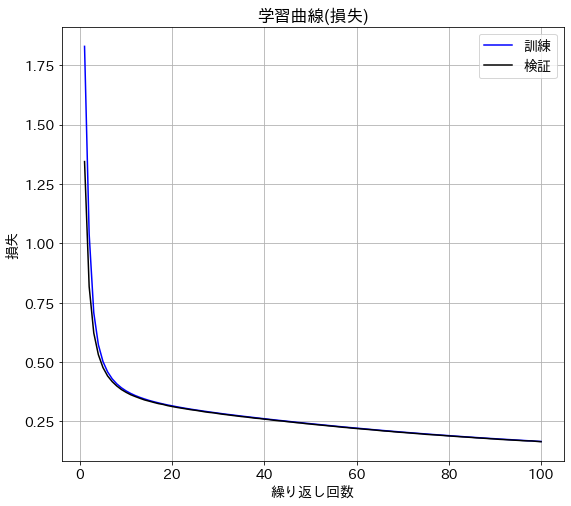

In [ ]:
# 学習曲線の表示 (損失)

plt.rcParams['figure.figsize'] = (9,8)
plt.plot(history[:,0], history[:,1], 'b', label='訓練')
plt.plot(history[:,0], history[:,3], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('損失')
plt.title('学習曲線(損失)')
plt.legend()
plt.show()

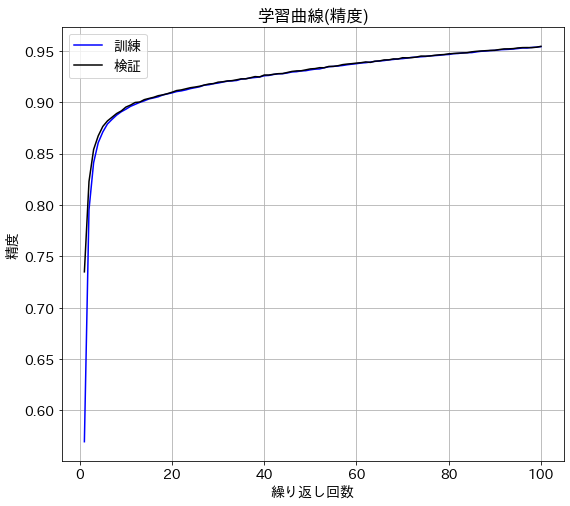

In [ ]:
# 学習曲線の表示 (精度)

plt.rcParams['figure.figsize'] = (9,8)
plt.plot(history[:,0], history[:,2], 'b', label='訓練')
plt.plot(history[:,0], history[:,4], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('精度')
plt.title('学習曲線(精度)')
plt.legend()
plt.show()

In [ ]:
#イメージで確認
#DataLoaderから最初に１セットを取得する
for images, labels in test_loader:
  break

#予測結果の取得
inputs = images.to(device)
labels = labels.to(device)
outputs = net(inputs)
predicted = torch.max(outputs, 1)[1]

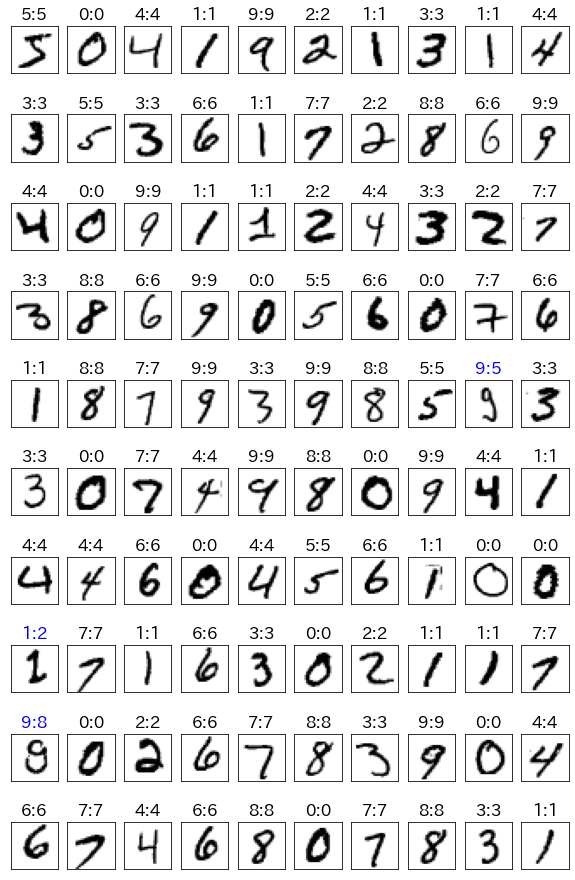

In [ ]:
#最初の100件でイメージを「正解値:予測値」と表示

plt.figure(figsize=(10,16))
for i in range(100):
  ax = plt.subplot(10, 10, i+1)

  #numpyに変換
  image = images[i]
  label = labels[i]
  pred = predicted[i]
  if (pred == label):
    c='k'
  else:
    c='b'

  #imgの範囲を[0, 1]に戻す
  image2 = (image + 1)/2

  #イメージ表示
  plt.imshow(image2.reshape(28, 28), cmap='gray_r')
  ax.set_title(f'{label}:{pred}', c=c)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()